# Unsupervised Learning on Country Data for HELP International

## Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

# Importing PCA and TSNE for data analysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Importing clustering and unsupervised learning algorithms like k-means, k-medoids, DBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Silhouette score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


## Loading the dataset as well as data dictionary to understand the data

In [3]:
data_dictionary_file = "../data/ds/data-dictionary.csv"
data_file = "../data/ds/Country-data.csv"

dd = pd.read_csv(data_dictionary_file)
data = pd.read_csv(data_file)
dd

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


## Data Information and problem status:
- There are 10 columns country, child_mortality, exports, health spending, imports, income per person, inflation rate, life expetancy of a new born child, total fertility rate and gdp per capita.
- Exports, Imports, inflation, gdpp give an estimate of economic information of the country.
- Child mortality, health, life expectancy of newborns and total fertility are related to social information of the country.
- Income is a parameter which is both social and economic information in it.
- We are required to find the socio-economic status of the countries based on these features. 

**Can we find a pattern and cluster similar countries and categorize the countries which require aid from HELP International.**

## Lets take a look at the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


In [6]:
data[data.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


## Observations
- We have 167 countries.
- There are no null values, the data is clean.
- Except for Country Name every parameter is numeric.
- Exports, health, imports, life_expec, total_fer have their standard deviations lower than mean which signifies these are clustered near the Mean, few of these parameters can help us find clusters.
- child_mort, income, inflation, gdpp are a little bit spread out.
- Data suggests there could be outliers mostly towards the max side, these could be developed countries.
- No duplicated values.

## Lets visualize the distribution and outliers

child_mort
Skew : 1.45


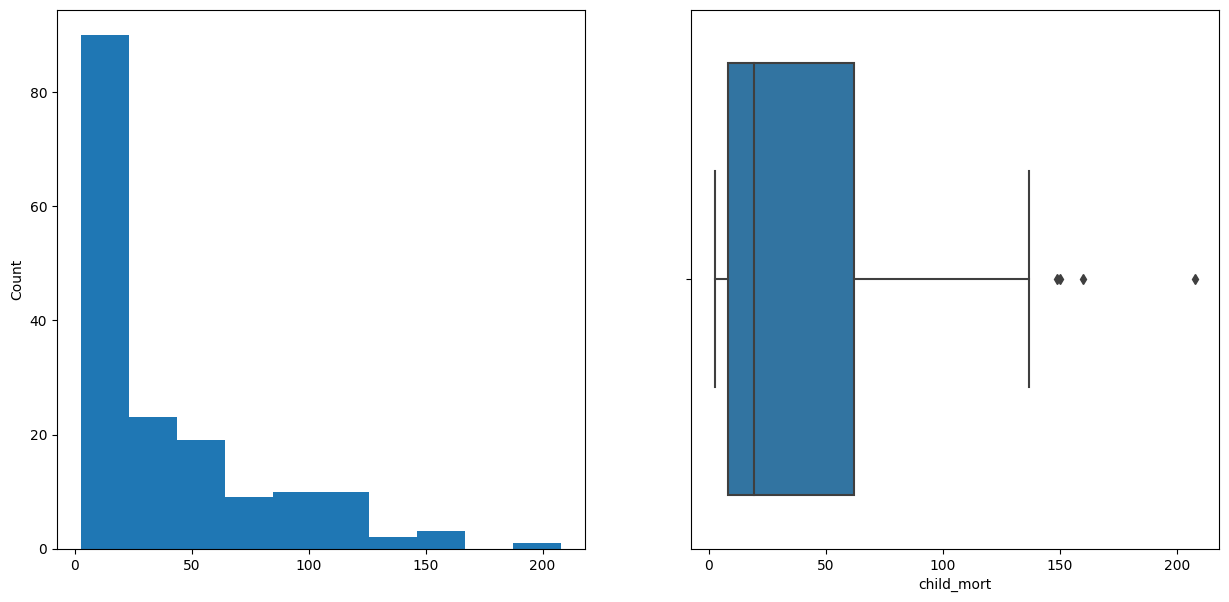

exports
Skew : 2.45


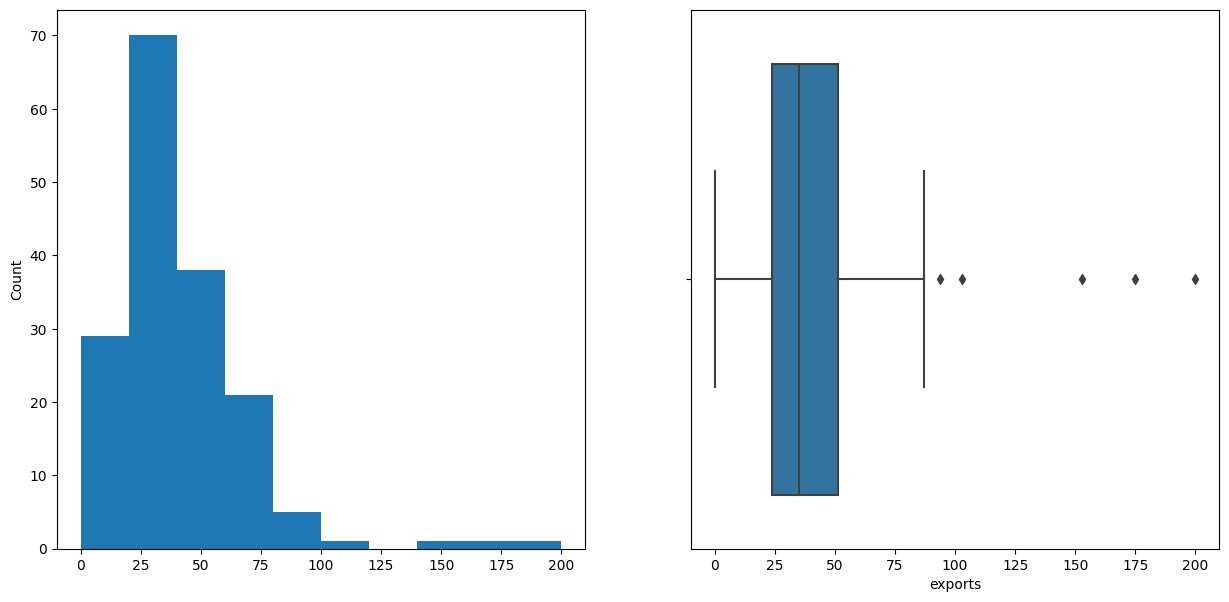

health
Skew : 0.71


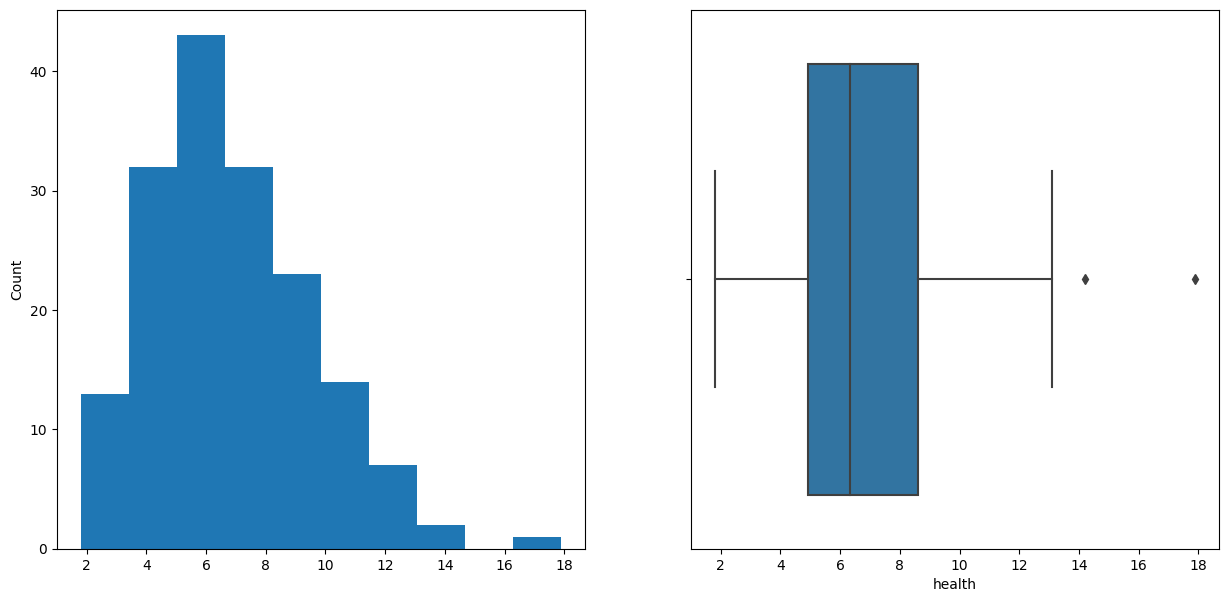

imports
Skew : 1.91


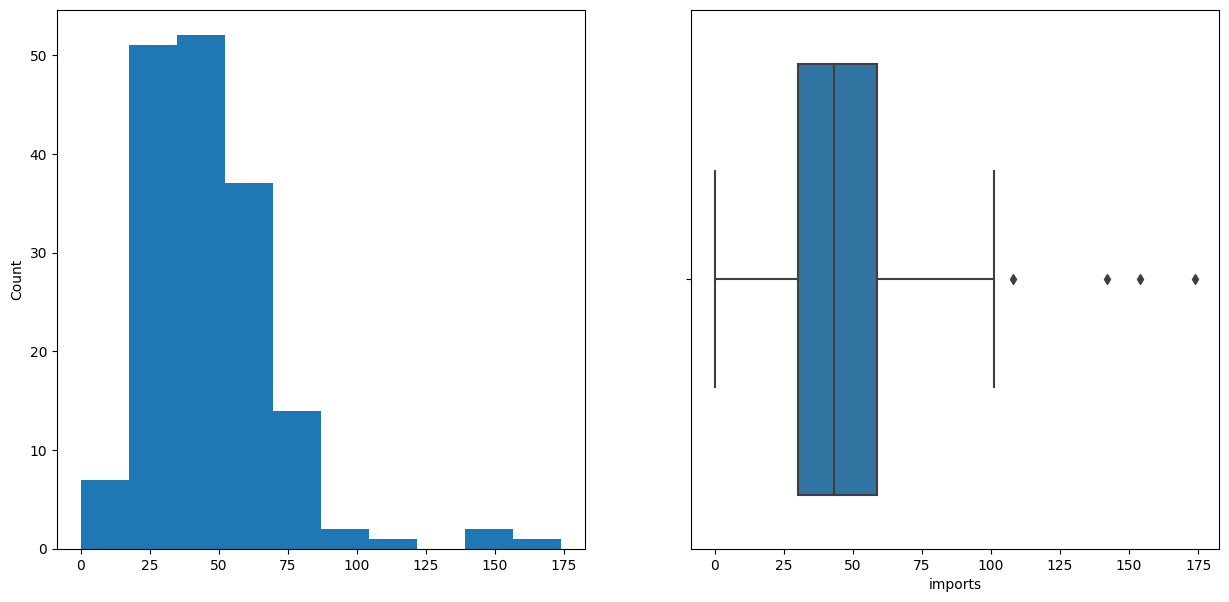

income
Skew : 2.23


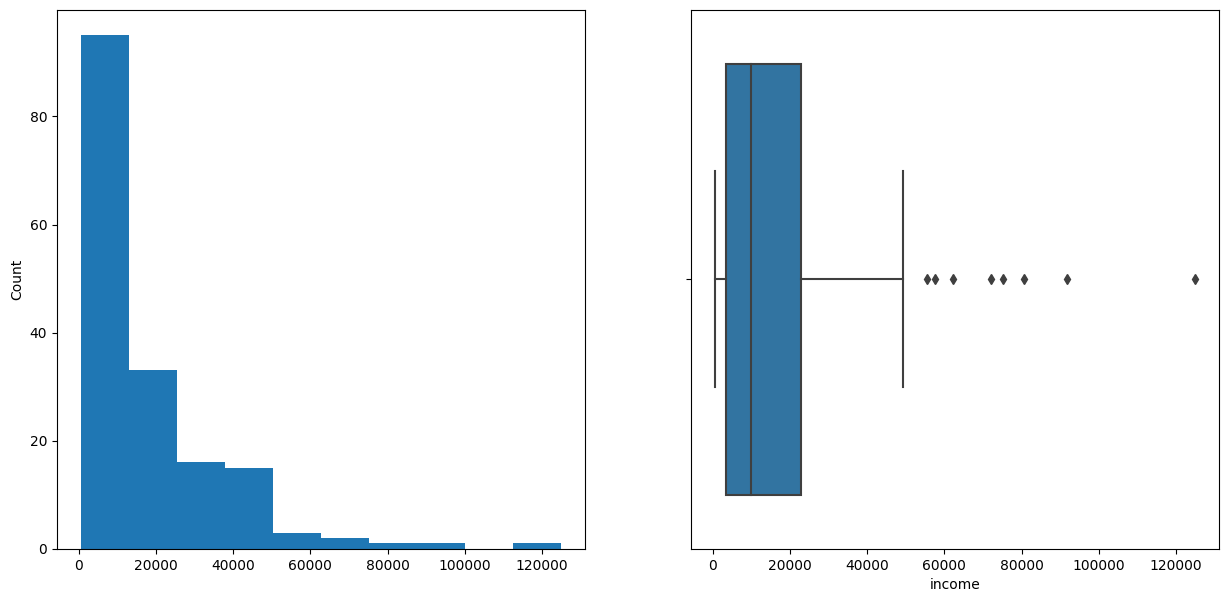

inflation
Skew : 5.15


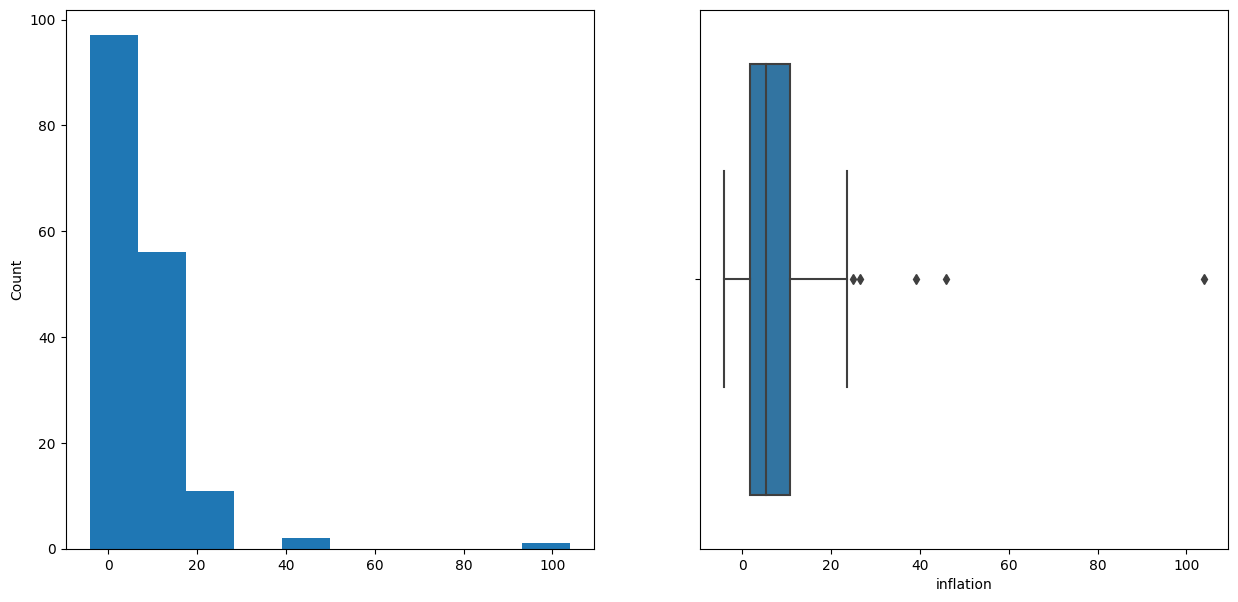

life_expec
Skew : -0.97


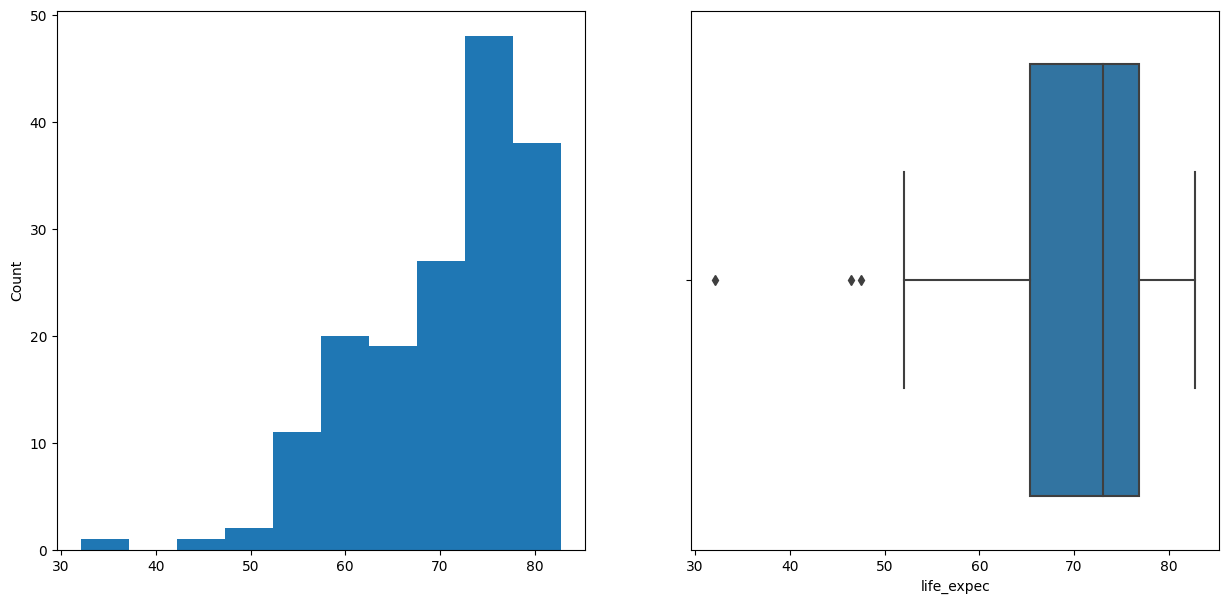

total_fer
Skew : 0.97


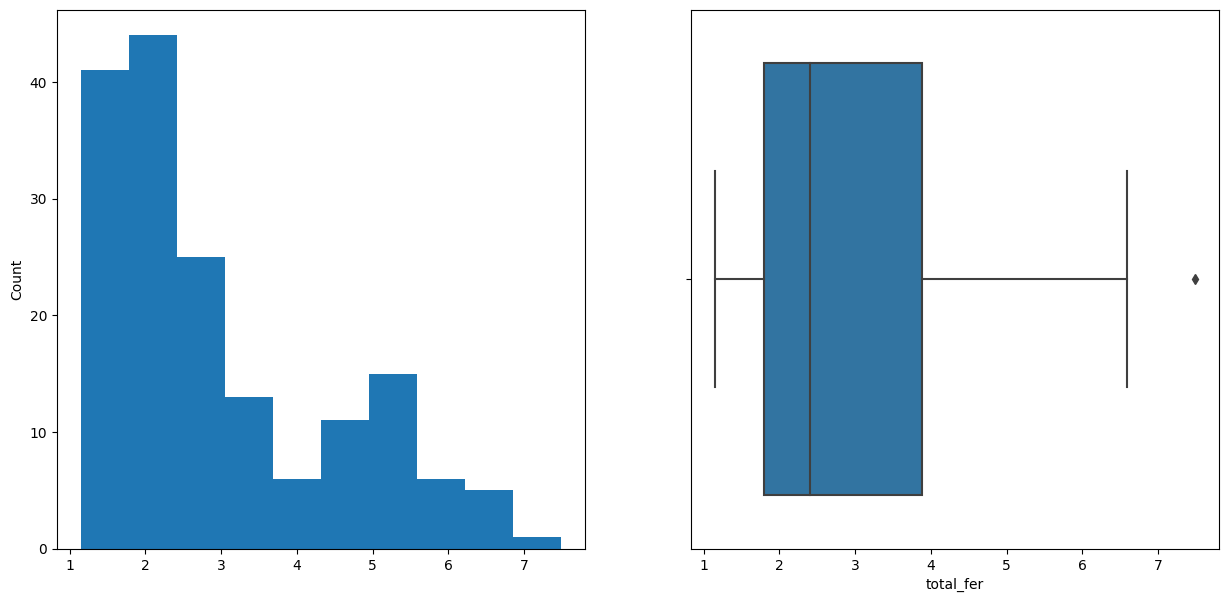

gdpp
Skew : 2.22


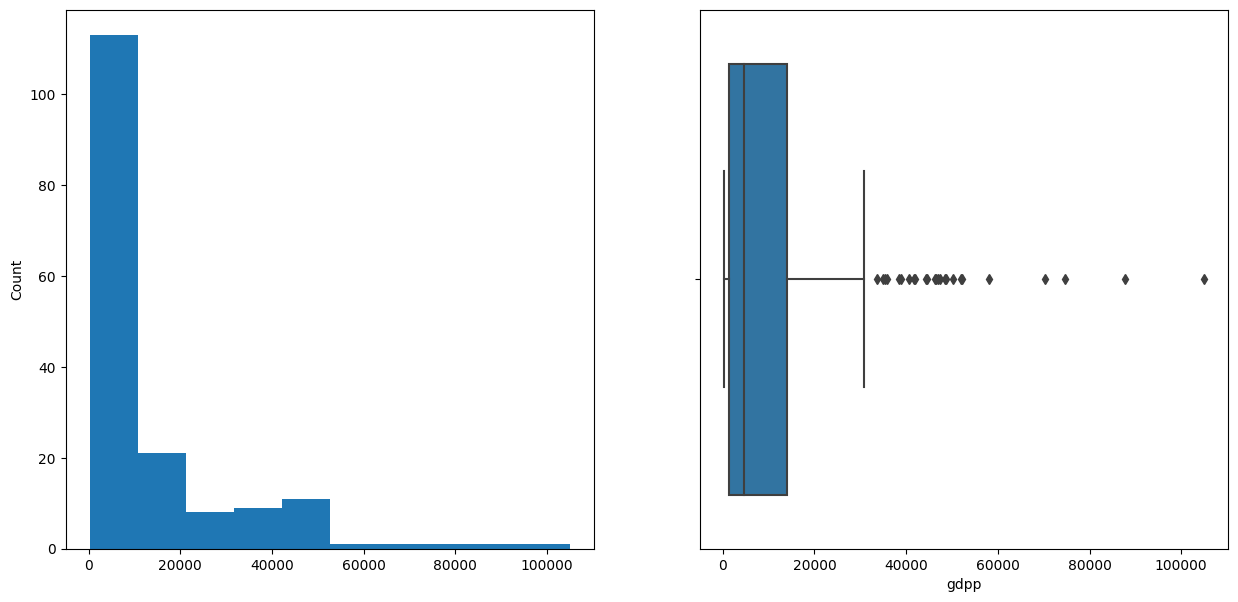

In [7]:
# Taking all columns expect the country name. (it does not make sense, Does it?)
for col in data.columns[1:]:
    print(col)
    print("Skew :", round(data[col].skew(), 2))
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel("Count")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

## Observations:
- As observed previously most of the data is skewed.
- The only variable which is left skewed is life expectancy, which signifies most countries have addressed this issue.
- Most have outliers in right.

## Checking the correlation amoung variables

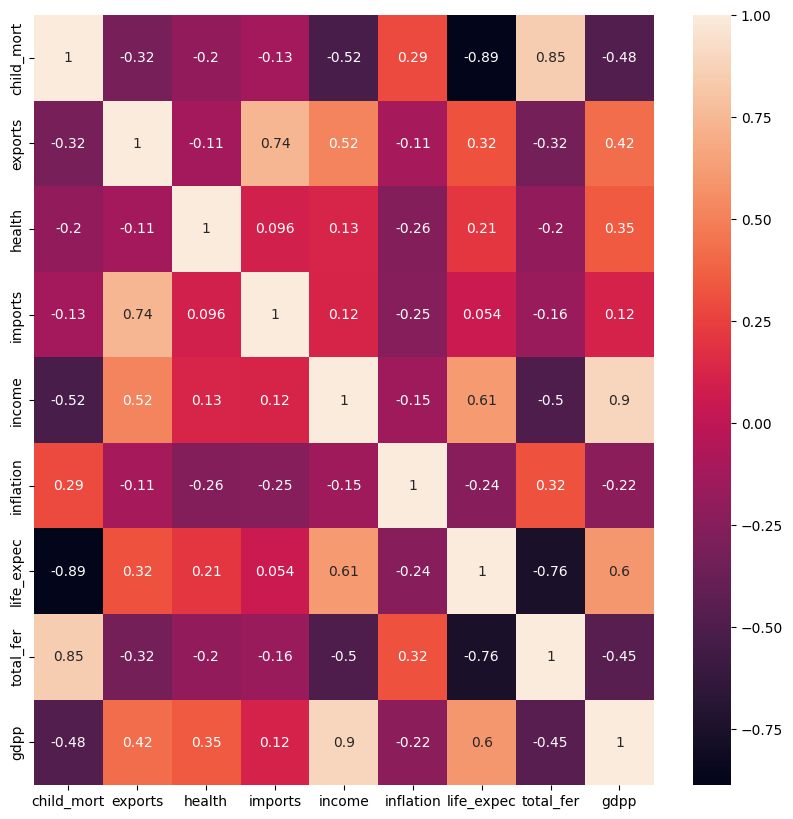

In [11]:
data_without_country = data.drop(columns=["country"])
plt.figure(figsize=(10, 10))
sns.heatmap(data_without_country.corr(), annot=True)
plt.show()

## Observations:
- **High Positive** correlation between variables:
    - child_mort and total_fer - which is expected
    - exports and imports
    - gdpp and income - which is expected
- **High Negative** correlation between variables:
    - child_mort and life_expec - which is expected
    - total_fer and life_expec - which is expected
- Other **Positive** Correlations
    - exports and income 
    - exports and gdpp
    - health and gdpp - Richer nations have better health spend.
    - income and life_expec - with better income life_expectancy of the child increases.
    - life_expec and gdpp - Rich nations have better child life expectancy.
- Other **Negative** Correlations
    - child_mort and income - with decrease in income (poor nations) child mortality is high.
    - child_mort and gdpp - Poorer nations have higher child mortality.
    - exports and child_mort - Nations where exports are high have high income and less child mortality.
    - inflation and health - Nations where inflation is high (economically affected countries) health spend is less.
    - income and total_fer 
    - life_expec and inflation - Countries which have taken measures to economically counter inflation have better life expectency for children.
    - total_fer and gdpp

## Insights
**After reading about GDP I have decided to drop it from this exploration**
- gdpp is a complex variable which encompasses income, inflation, import, export etc and calculated for a country and using this for clustering along with its component variables might not give us desired result.
- Also gdpp includes government spend and might not capture actual state of social situation.
- Droping gdpp is a good idea.
- ###### HBR Article for reference: https://hbr.org/2019/10/gdp-is-not-a-measure-of-human-well-being

In [12]:
data_for_clustering = data_without_country.drop(columns=["gdpp"])

# Scaling the data and storing it in a new dataframe
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_for_clustering), columns=data_for_clustering.columns)
data_scaled.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946


## Principal Component Analysis (PCA)

In [13]:
#Defining the number of principal components to generate 
n=data_scaled.shape[1]

#Finding principal components for the data
pca = PCA(n_components=n, random_state=1)
data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative Explained Variance')

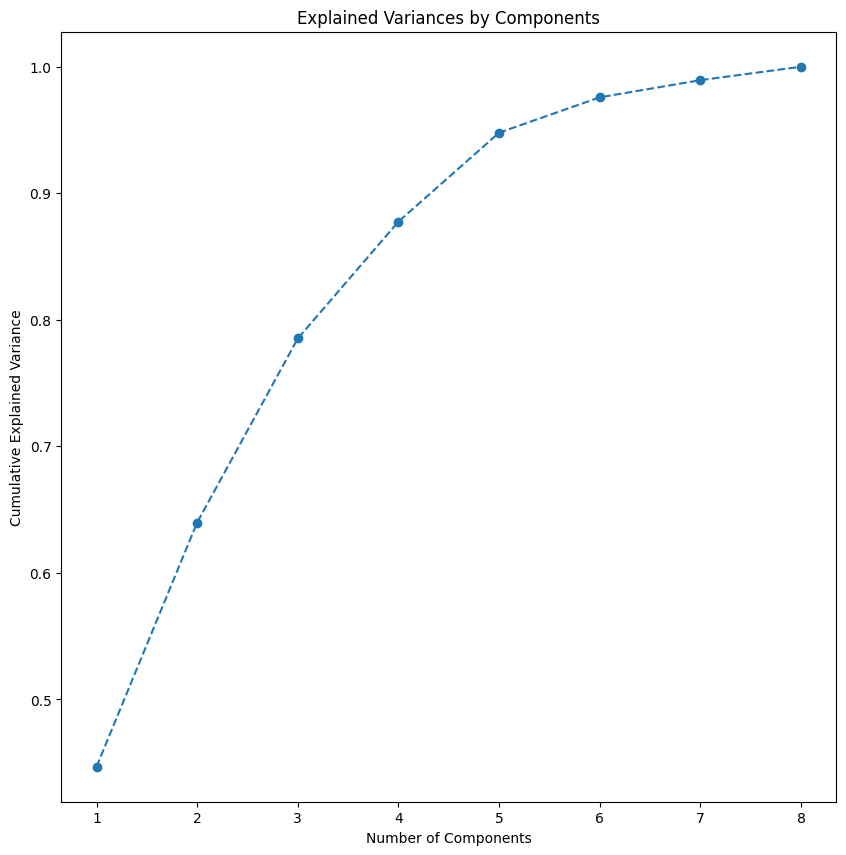

In [16]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,9), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [17]:
# find the least number of components that can explain more than 75% variance
sum = 0
for ix, i in enumerate(exp_var):
  sum = sum + i
  if(sum>0.75):
    print("Number of PCs that explain at least 75% variance: ", ix+1)
    break

Number of PCs that explain at least 75% variance:  3


## Observations
- 3 Principle components can explain more than 75% of variance in data. Actually almost 79%.
**Let us look at these 3 principle components as linear combinations of original features.**

In [18]:
pc_comps = ['PC1','PC2','PC3']
data_pca = pd.DataFrame(np.round(pca.components_[:3,:],2),index=pc_comps,columns=data_scaled.columns)
data_pca.T

,PC1,PC2,PC3
child_mort,-0.47,0.21,-0.10
exports,0.31,0.61,0.15
health,0.14,-0.24,-0.65
imports,0.19,0.66,-0.29
income,0.39,0.03,0.25
inflation,-0.22,0.01,0.62
life_expec,0.46,-0.24,0.16
total_fer,-0.46,0.18,-0.05


## Observations:
- For decision making almost 63% of data is captured by first two principle components.
- A weight of 0.25 might be a good candidate for explanation of significance.

In [21]:
def color_high(val):
    if val <-0.25:
        return 'background: pink'
    elif val >0.25:
        return 'background: skyblue'   
    
data_pca.T.style.applymap(color_high)

,PC1,PC2,PC3
child_mort,-0.470000,0.210000,-0.100000
exports,0.310000,0.610000,0.150000
health,0.140000,-0.240000,-0.650000
imports,0.190000,0.660000,-0.290000
income,0.390000,0.030000,0.250000
inflation,-0.220000,0.010000,0.620000
life_expec,0.460000,-0.240000,0.160000
total_fer,-0.460000,0.180000,-0.050000


## Observations:
- PC1 is explaining the Social factors and related economic factors (income and exports which we saw in correlation matrix analysis)
- PC2 is explaining countries foreign trade such as imports and exports.
- PC3 is explaining the economic factors related to inflation and its ditrimental effects on health expenditure as well as import capabilities.

## Lets visualize the relations between PC1&PC2, PC2&PC3 and PC1&PC3

Text(0, 0.5, 'PC2')

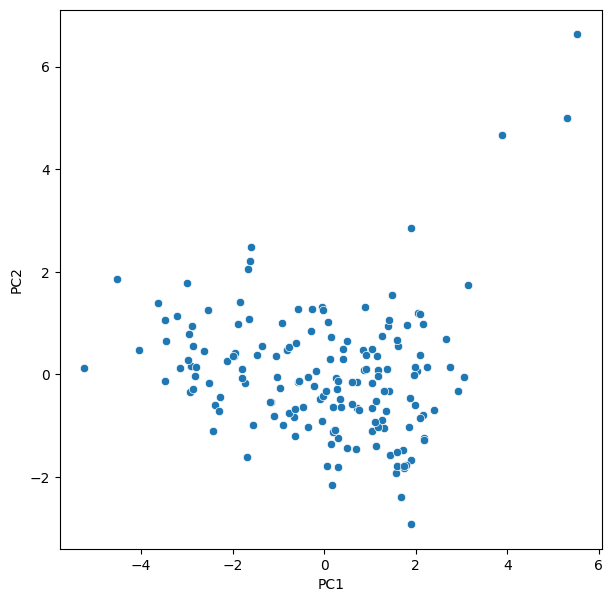

In [22]:
plt.figure(figsize = (7,7))
sns.scatterplot(x=data_pca1[0],y=data_pca1[1])
plt.xlabel("PC1")
plt.ylabel("PC2")

## Conclusion on PCA:
- While we were able to find correlations, able to decrease the dimensions to 3 at max. and PC1 PC2 explaining almost 63% of data, we could not find a clustering pattern with it.
- It was a useful exercise in understanding the data and cause-effect realtionship.

**Lets look at TSNE**

<Axes: xlabel='X1', ylabel='X2'>

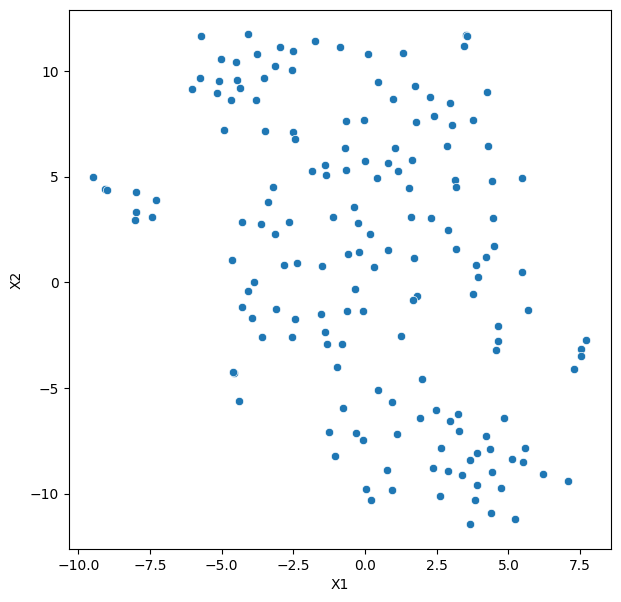

In [25]:
#Fitting TSNE with number of components equal to 2 
tsne = TSNE(n_components = 2, random_state=1)
data_tsne = tsne.fit_transform(data_scaled)
#Converting the embeddings to a dataframe
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2'])
#Scatter plot for two components
plt.figure(figsize = (7,7))
sns.scatterplot(x = 'X1', y='X2', data = data_tsne)

## Observations:
- We could not identify any clusters with t-SNE with 2 dimensions.

**Lets try with 3 dimensions**

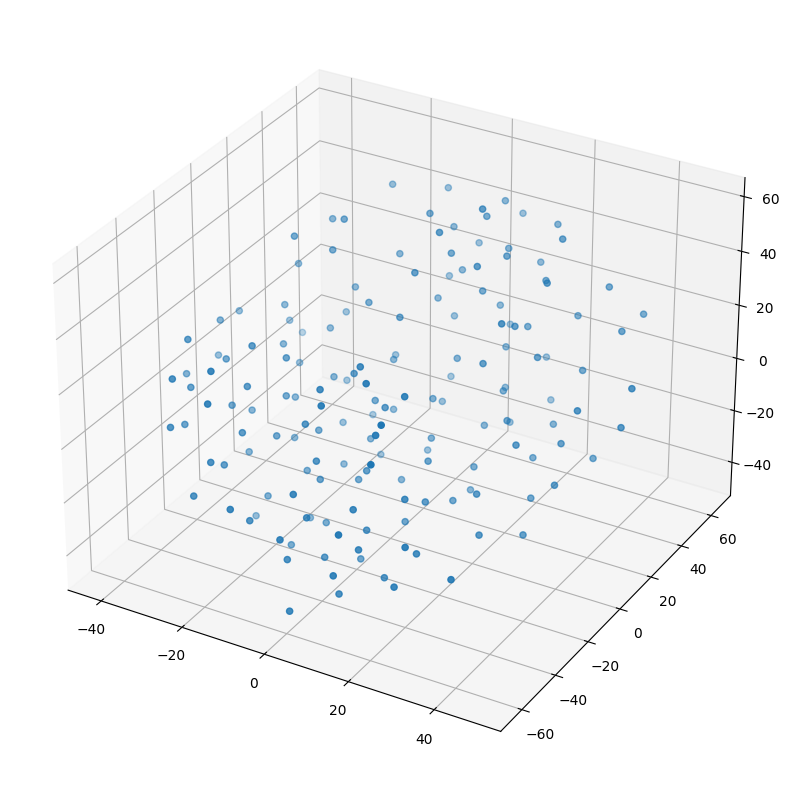

In [26]:
#Fitting TSNE with number of components equal to 2 
tsne = TSNE(n_components = 3, random_state=1)
data_tsne = tsne.fit_transform(data_scaled)
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2', 'X3'])
#Scatter plot for all three components
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x = data_tsne['X1']
y = data_tsne['X2']
z = data_tsne['X3']

ax.scatter(x, y, z)

## Conclusion on t-SNE
- As we can see from above graphs neither from 2d or 3d we could find clusters.
- While PCA and t-SNE are good candidates to find clusters, this dataset does not exhibit characteristics that could be captured. 

**Maybe just maybe we can check with different perplexity if we could find any clusters**

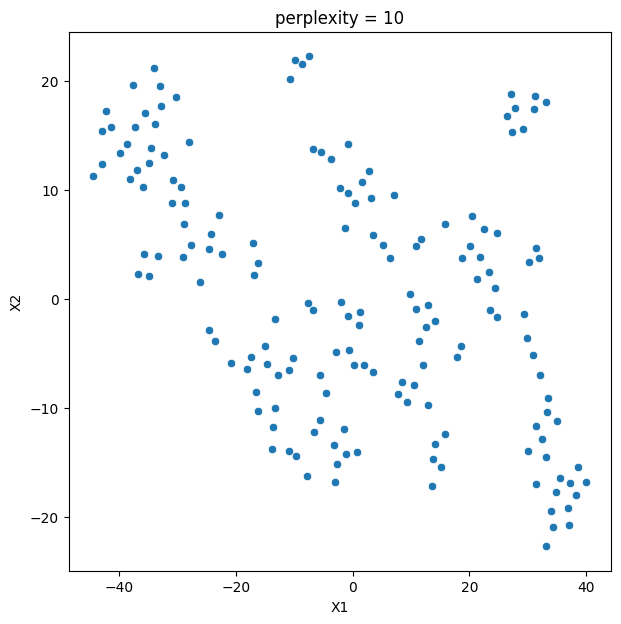

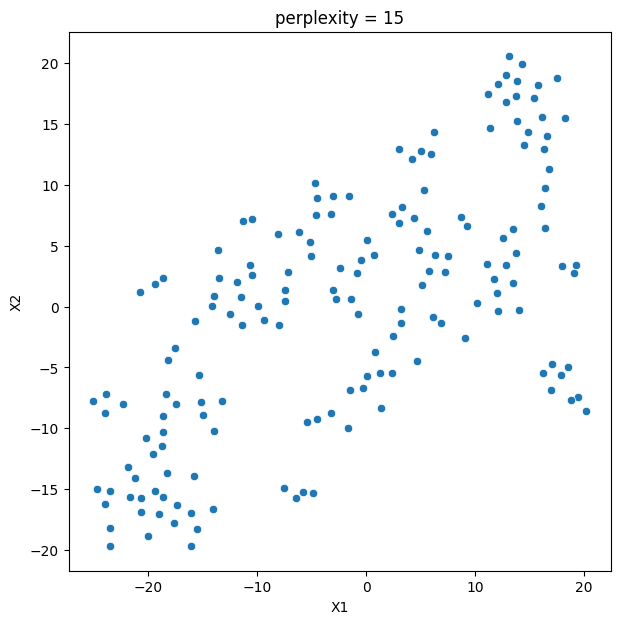

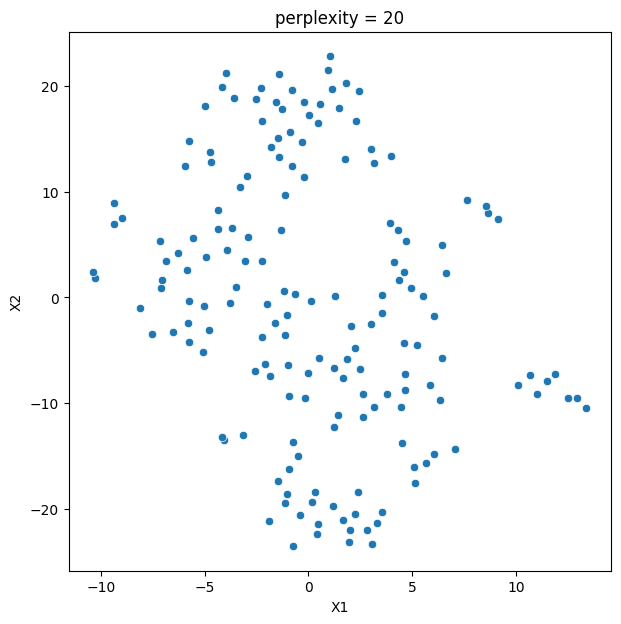

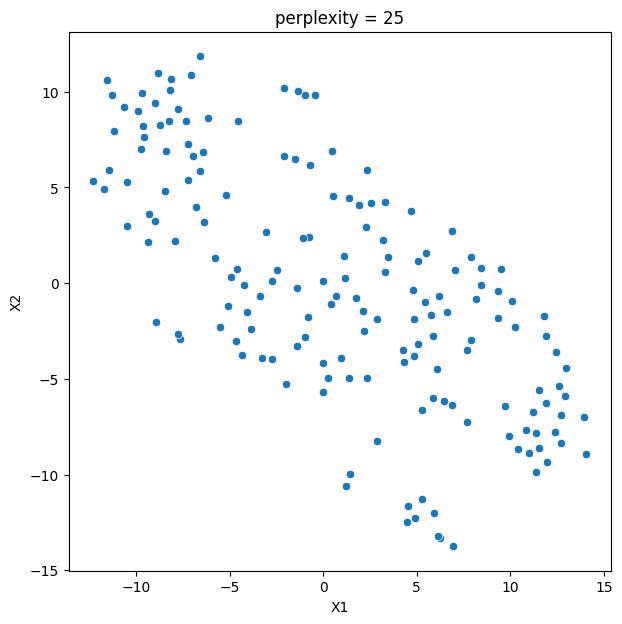

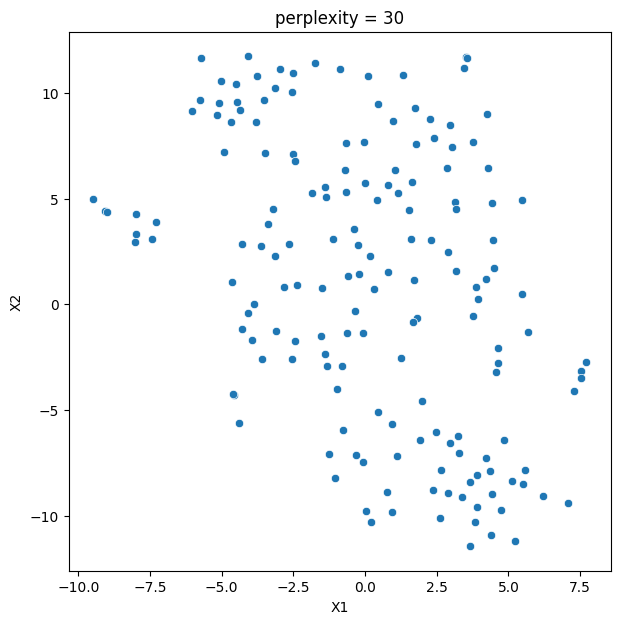

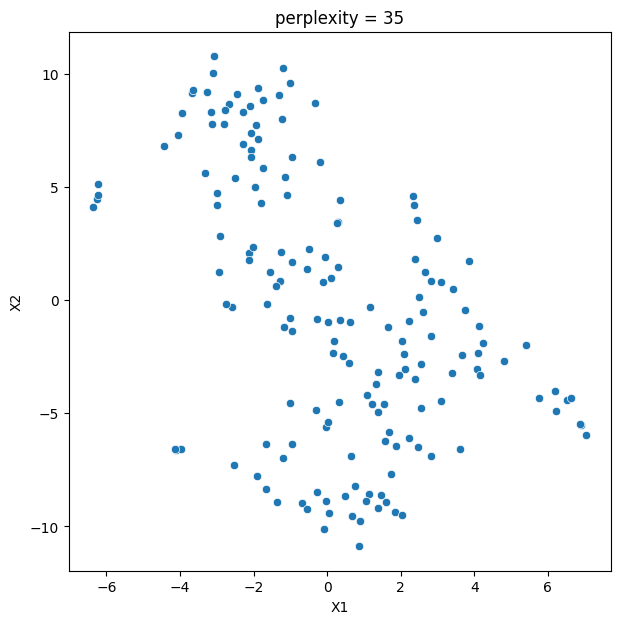

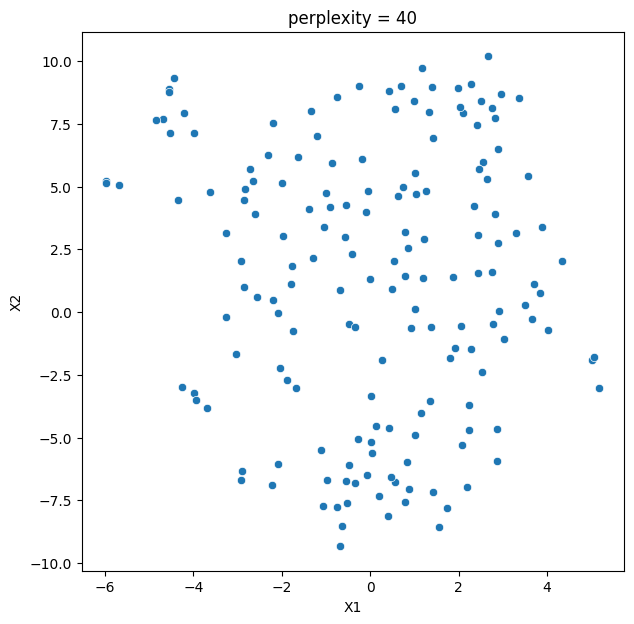

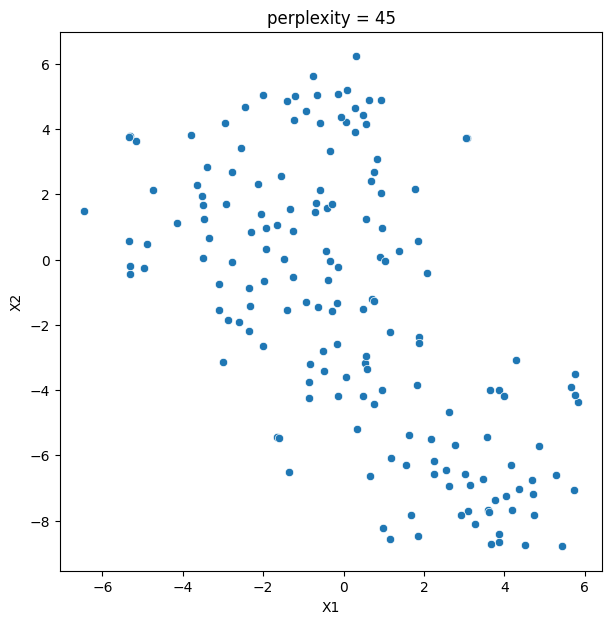

In [27]:
for i in range(10, 50, 5):
    tsne = TSNE(n_components = 2, random_state=1, perplexity=i)
    data_tsne = tsne.fit_transform(data_scaled)
    data_tsne = pd.DataFrame(data_tsne)
    data_tsne.columns = ['X1', 'X2']
    plt.figure(figsize = (7,7))
    sns.scatterplot(x = 'X1', y='X2', data = data_tsne)
    plt.title("perplexity = {}".format(i))

### No underlying pattern could be identified with t-SNE, Lets go for Clustering Algorithms

**Before going to clustering methods, lets create deep copy for labels from each algorithm**

In [28]:
data_scaled_copy = data_scaled.copy(deep=True)

## K-Means Clustering Algo implementation

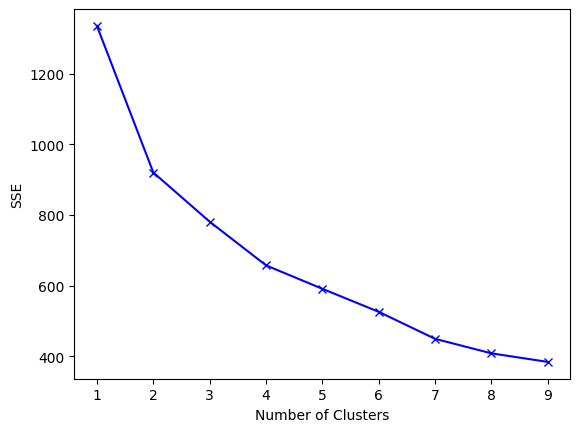

In [29]:
#Empty dictionary to store the SSE (sum of Squares errors) for each value of k
sse = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

# Plotting the findings
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), "bx-")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Observations
- After 2 to 9 we do not see any elbow, its a consistant dip.

**Lets see if could get any more information from Silhoutte score**

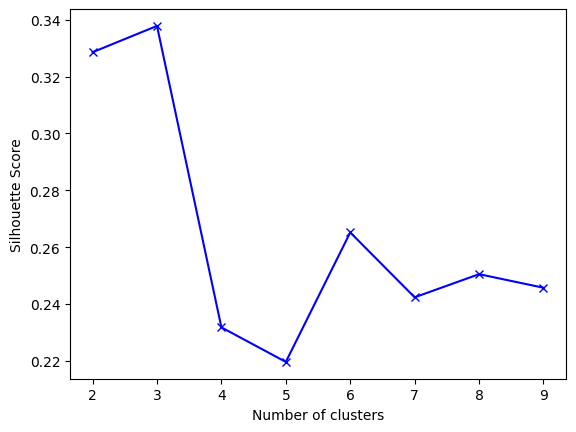

In [31]:
# Silhoutte score dict
sc = {}

# iterating over a range of ks fitting it to k-means and getting the silhoute score for each.
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

# Lets plot the finding - Maybe we will find an elbow
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

## Observations:
- Silhouette score is highest for k = 3. Lets go with 3 clusters.

In [38]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled)

# Adding predicted Labels to scaled data and original data
data_scaled_copy["kmean_labels"] = kmeans.predict(data_scaled)
data_without_country["kmean_labels"] = kmeans.predict(data_scaled)

data_without_country["kmean_labels"].value_counts()

kmean_labels
0    107
2     51
1      9
Name: count, dtype: int64

**Very Skewed clustering, very few in one cluster and more than 100 in another cluster**
- Lets check what came up in each cluster

In [40]:
# Lets get mean and median for each variable in the dataset
mean = data_without_country.groupby("kmean_labels").mean()
median = data_without_country.groupby("kmean_labels").median()

# Creating dataframe with means and medians 
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ["Group1_mean", "Group2_mean", "Group3_mean", "Group1_median", "Group2_median", "Group3_median"]
df_kmeans.T

,Group1_mean,Group2_mean,Group3_mean,Group1_median,Group2_median,Group3_median
child_mort,16.339252,7.766667,89.664706,14.20,8.60,88.20
exports,41.208224,110.988889,28.569000,38.40,93.80,23.80
health,7.228972,4.878889,6.290392,6.85,3.66,5.66
imports,45.459813,90.033333,42.277763,44.50,86.50,40.30
income,19338.785047,66288.888889,3868.882353,15400.00,72100.00,1930.00
inflation,6.093056,5.261556,11.769706,3.80,3.83,8.92
life_expec,75.021495,78.822222,59.727451,75.40,79.50,60.40
total_fer,2.129159,1.816667,4.865490,1.98,1.87,5.02
gdpp,15504.635514,45700.000000,1857.215686,8080.00,38500.00,967.00


## Insights:
- Group2 has high income, high exports, low child mortality, and high GDP per capita, These are definitely Rich and developed countries.
- Group 3 has high child mortality, low income, low life expectancy, a good amount of health expenditure, high inflation. This group contains our focus group of countries which need HELP foundations services. There are around 9 countries which need the services.
- Group 1 are in between the two and can be categorized as developing countries. Naturally they have the highest number.

**Do we have outliers in this making our above insights wrong. Lets check the box plots**

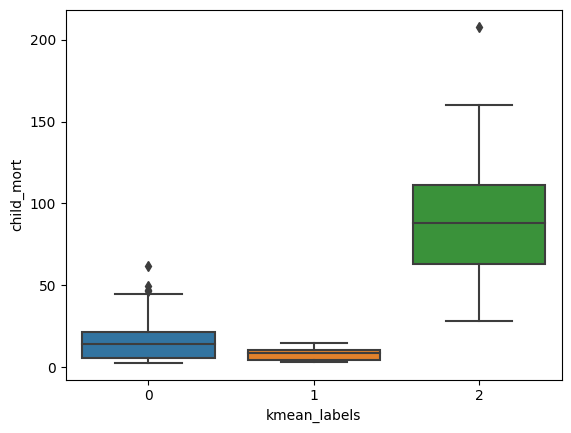

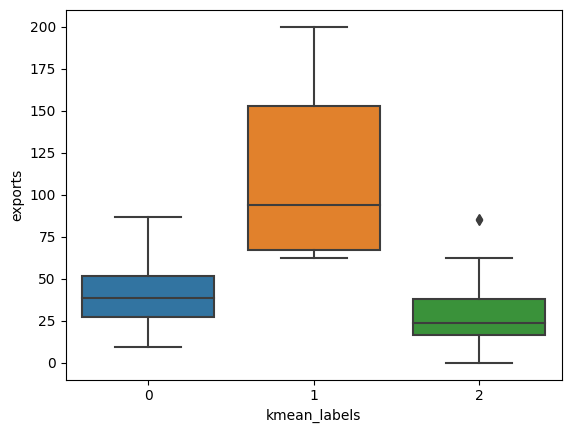

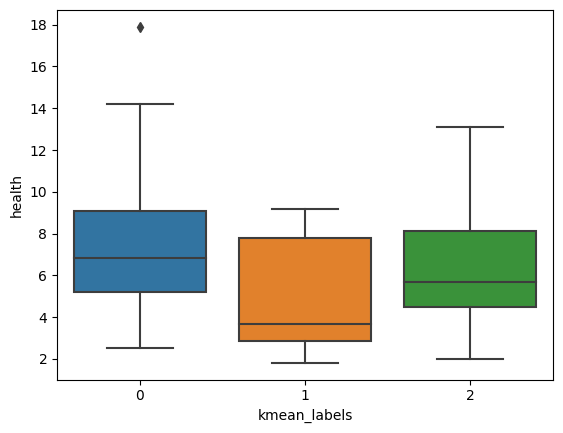

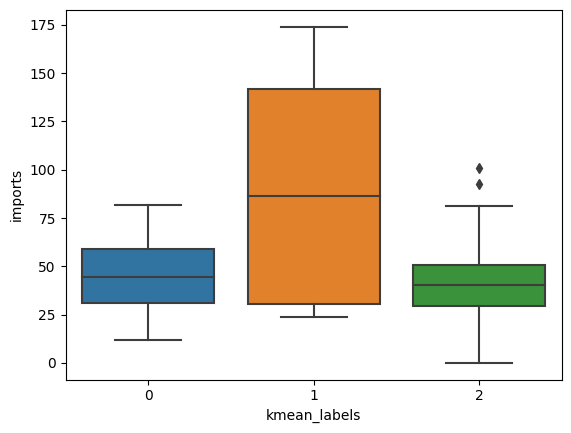

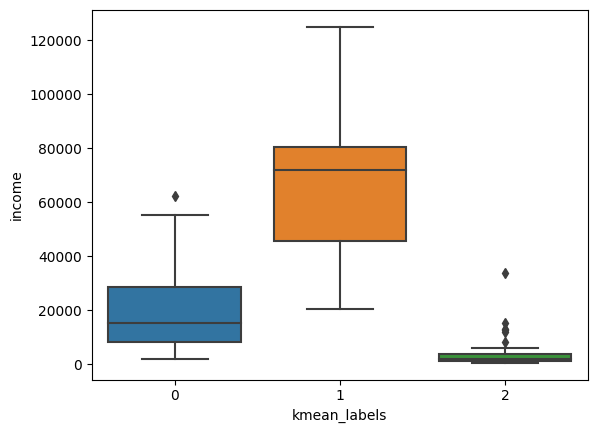

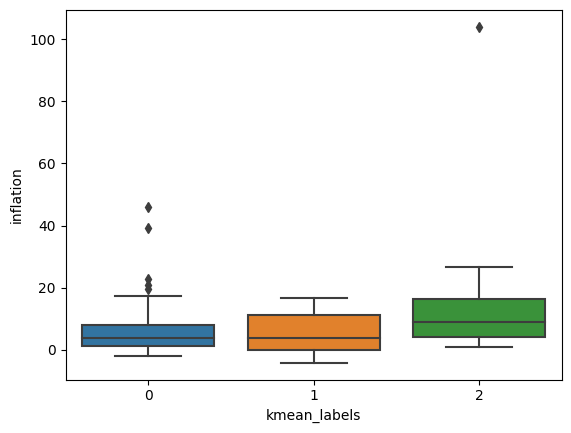

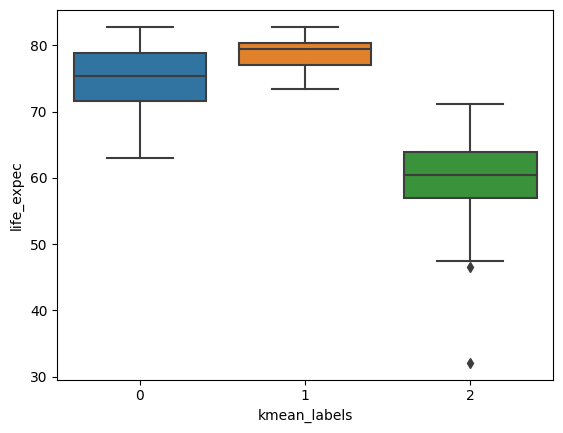

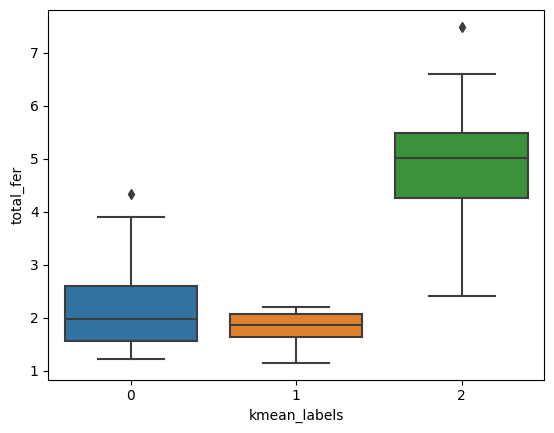

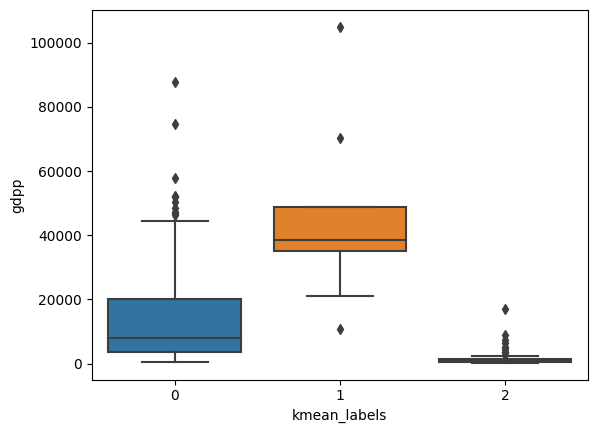

In [41]:
view_cols = []
for col in data_without_country.columns:
    if col != "kmean_labels":
        view_cols.append(col)
for col in view_cols:
    sns.boxplot(x="kmean_labels", y=col, data=data_without_country)
    plt.show()

## Conclusion on K-Means:
- While this algorithm gives a good indication on potential clusters. There are lot of outliers which are skewing the info to make it one small cluster and two large clusters.

**As Final check lets see if the clusters correlate well with GDP.**

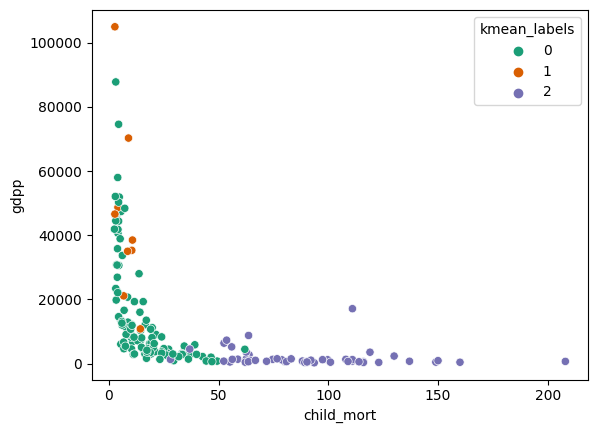

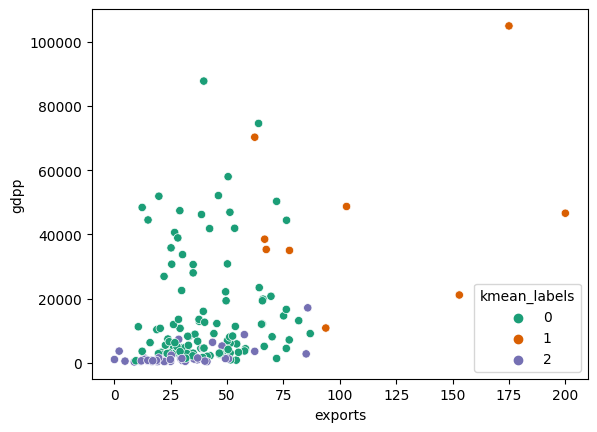

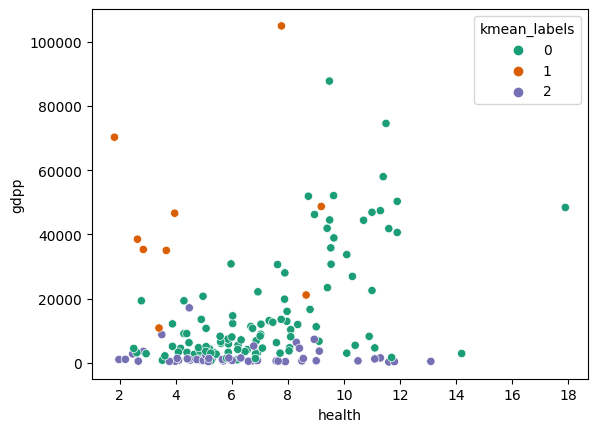

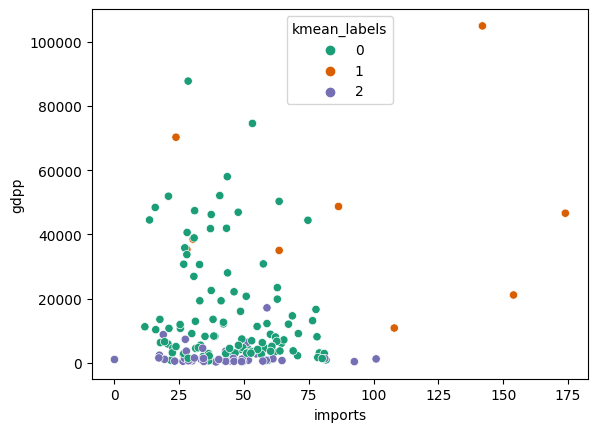

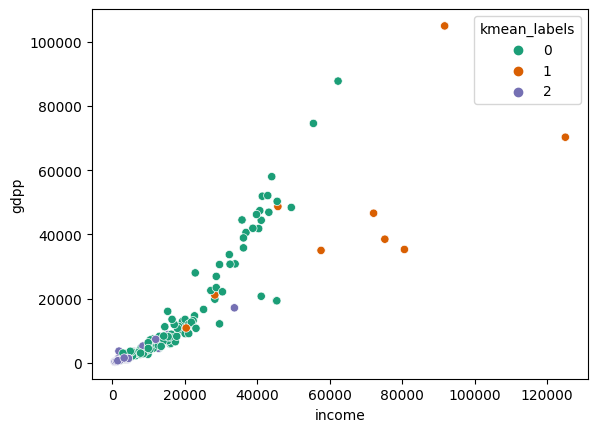

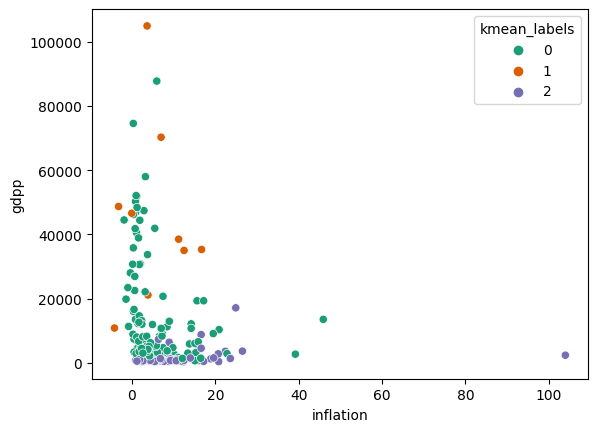

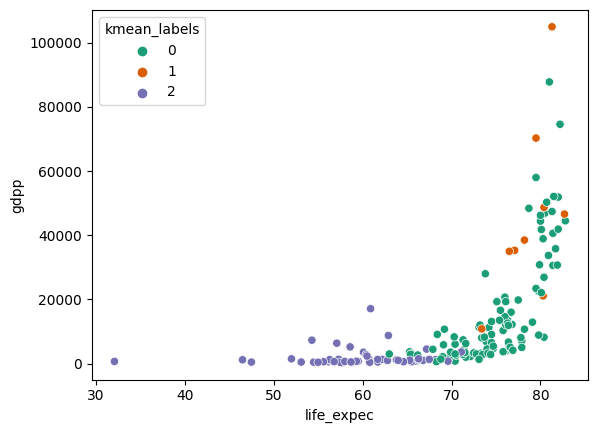

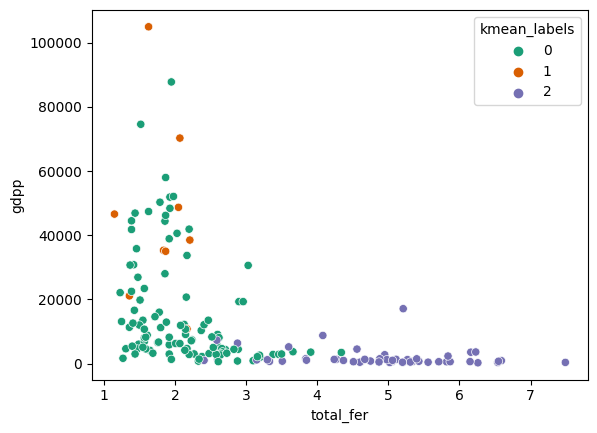

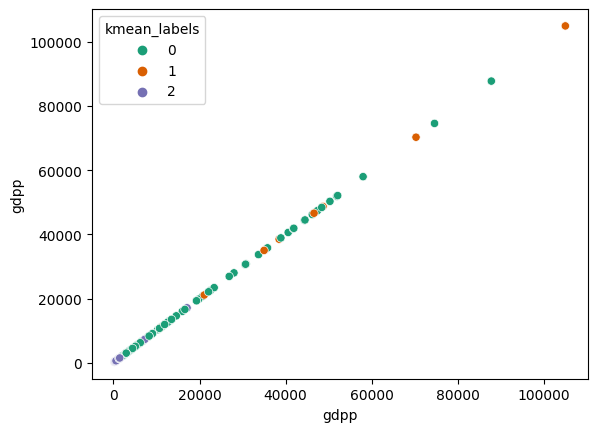

In [47]:
for col in view_cols:
    sns.scatterplot(x=col, y="gdpp", data=data_without_country, hue="kmean_labels", palette="Dark2")
    plt.show()

## Observations:
- As fertility increases the population of the country increase which results in lower GDP and net income per person.
- Child mortality also negatively impacts the GDP of the country. High child mortality can be due to several reasons like higher population of the country, poverty or lower net income per person, lack of health facilities, etc.

## Lets check with k-medoids

In [49]:
from sklearn_extra.cluster import KMedoids

kmedo = KMedoids(n_clusters=3, random_state=1)
kmedo.fit(data_scaled)
data_scaled_copy["kmedoid_labels"] = kmedo.predict(data_scaled)
data_without_country["kmedoid_labels"] = kmedo.predict(data_scaled)

data_without_country["kmedoid_labels"].value_counts()

kmedoid_labels
1    75
2    58
0    34
Name: count, dtype: int64

## Observations:
- K-Medoids gives us better clustering.

In [50]:
mean = data_without_country.groupby("kmedoid_labels").mean()
median = data_without_country.groupby("kmedoid_labels").median()

df_kmedo = pd.concat([mean, median], axis=0)
df_kmedo.index = ["group_0_mean", "group_1_mean", "group_2_mean", "group_0_median", "group_1_median", "group_2_median"]
df_kmedo.T

,group_0_mean,group_1_mean,group_2_mean,group_0_median,group_1_median,group_2_median
child_mort,7.085294,17.853333,82.951724,4.700,15.70,79.600
exports,36.938235,52.989333,28.191362,31.600,48.30,23.800
health,9.413235,6.202133,6.086379,9.585,6.00,5.275
imports,33.452941,57.694667,40.795964,30.750,55.10,36.800
income,38094.705882,17592.800000,4284.189655,36550.000,13500.00,2145.000
inflation,4.020676,5.511573,12.922328,1.825,3.82,9.225
life_expec,79.614706,73.870667,60.958621,80.200,74.10,60.800
total_fer,1.842353,2.179600,4.589655,1.875,2.13,4.875
gdpp,35925.588235,10989.813333,2057.034483,38700.000,6230.00,994.000
kmean_labels,0.088235,0.080000,1.758621,0.000,0.00,2.000


## Observations:
- Group 0 is a cohort of rich countries, with high gdpp and income. health expenditure is quite significant, life expectancy is high and low fertility rate. 
- Group 2 is a cohort of poor countries with low life expectancy, high inflation, high total_fer and high child mortality.
- Group 1 is a cohort of developed and developing nations.

In [54]:
data["kmedoid_labels"] = kmedo.predict(data_scaled)

print("Countries to concentrate on using K Medoids")
data[data["kmedoid_labels"] == 2]



Countries to concentrate on using K Medoids


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmean_labels,kmedoid_labels
0,Afghanistan,90.2,10.000,7.58,44.9000,1610,9.440,56.2,5.82,553,2,2
3,Angola,119.0,62.300,2.85,42.9000,5900,22.400,60.1,6.16,3530,2,2
12,Bangladesh,49.4,16.000,3.52,21.8000,2440,7.140,70.4,2.33,758,0,2
17,Benin,111.0,23.800,4.10,37.2000,1820,0.885,61.8,5.36,758,2,2
21,Botswana,52.5,43.600,8.30,51.3000,13300,8.920,57.1,2.88,6350,2,2
25,Burkina Faso,116.0,19.200,6.74,29.6000,1430,6.810,57.9,5.87,575,2,2
26,Burundi,93.6,8.920,11.60,39.2000,764,12.300,57.7,6.26,231,2,2
28,Cameroon,108.0,22.200,5.13,27.0000,2660,1.910,57.3,5.11,1310,2,2
31,Central African Republic,149.0,11.800,3.98,26.5000,888,2.010,47.5,5.21,446,2,2
32,Chad,150.0,36.800,4.53,43.5000,1930,6.390,56.5,6.59,897,2,2


In [55]:
print("Countries to concentrate on using k means")
data[data["kmean_labels"] == 2]

Countries to concentrate on using k means


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmean_labels,kmedoid_labels
0,Afghanistan,90.2,10.000,7.58,44.9000,1610,9.440,56.2,5.82,553,2,2
3,Angola,119.0,62.300,2.85,42.9000,5900,22.400,60.1,6.16,3530,2,2
17,Benin,111.0,23.800,4.10,37.2000,1820,0.885,61.8,5.36,758,2,2
21,Botswana,52.5,43.600,8.30,51.3000,13300,8.920,57.1,2.88,6350,2,2
25,Burkina Faso,116.0,19.200,6.74,29.6000,1430,6.810,57.9,5.87,575,2,2
26,Burundi,93.6,8.920,11.60,39.2000,764,12.300,57.7,6.26,231,2,2
28,Cameroon,108.0,22.200,5.13,27.0000,2660,1.910,57.3,5.11,1310,2,2
31,Central African Republic,149.0,11.800,3.98,26.5000,888,2.010,47.5,5.21,446,2,2
32,Chad,150.0,36.800,4.53,43.5000,1930,6.390,56.5,6.59,897,2,2
36,Comoros,88.2,16.500,4.51,51.7000,1410,3.870,65.9,4.75,769,2,2


# Conclusion

**Both K-Means and k-Medoids algorithms give a fair clustering for countries to focus on for HELP foundation. which is Group2.**
